In [1]:
import xarray as xr
import numpy as np
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

import glob

In [2]:
ssp_colors = {"evaluation":"k",
              "historical":"grey",
              "ssp585":(149/255,27/255,30/255),
              "ssp370":(231/255,29/255,37/255),
              "ssp245":(247/255,148/255,32/255),
              "ssp126":(23/255,60/255,102/255),
              "ssp119":(0/255,173/255,207/255),}

In [3]:
list_evaluation = ['evaluation_BARRA-R_r1i1p1f1',
                   'evaluation_ERA5_r1i1p1f1',
                  ]

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

list_ssp126 = [
                 'ssp126_ACCESS-CM2_r4i1p1f1', # need to fix this one
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',
              ]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',
              ]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

list_future = list_ssp126 + list_ssp370 + list_ssp585

In [4]:
evaluation_kstest = pd.read_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_table.csv", index_col=0,).replace(np.nan, "")
evaluation_ttest = pd.read_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_ttest_p33_table.csv", index_col=0,)[["p33_pvalue", "significance"]].replace(np.nan, "")

In [5]:
evaluation_combined = pd.concat([evaluation_kstest, evaluation_ttest], axis=1, join="inner")
evaluation_combined["combined_significance"] = evaluation_kstest["significance"] + evaluation_ttest["significance"]
evaluation_combined

sample1                         sample2  \
0    evaluation_BARRA-R_r1i1p1f1  historical_ACCESS-CM2_r4i1p1f1   
1    evaluation_BARRA-R_r1i1p1f1  historical_ACCESS-CM2_r4i1p1f1   
2    evaluation_BARRA-R_r1i1p1f1  historical_ACCESS-CM2_r4i1p1f1   
3    evaluation_BARRA-R_r1i1p1f1  historical_ACCESS-CM2_r4i1p1f1   
4    evaluation_BARRA-R_r1i1p1f1  historical_ACCESS-CM2_r4i1p1f1   
..                           ...                             ...   
114  evaluation_BARRA-R_r1i1p1f1  historical_NorESM2-MM_r1i1p1f1   
115  evaluation_BARRA-R_r1i1p1f1  historical_NorESM2-MM_r1i1p1f1   
116  evaluation_BARRA-R_r1i1p1f1  historical_NorESM2-MM_r1i1p1f1   
117  evaluation_BARRA-R_r1i1p1f1  historical_NorESM2-MM_r1i1p1f1   
118  evaluation_BARRA-R_r1i1p1f1  historical_NorESM2-MM_r1i1p1f1   

    time_selection mon/seas/yr  pvalue significance  p33_pvalue significance  \
0           annual        year   0.310                    0.045            *   
1              DJF      season   0.999                    0.209                
2              MAM      season   0.150                    0.150                
3              JJA      season   0.082                    0.158                
4              SON      season   0.212                    0.099                
..             ...         ...     ...          ...         ...          ...   
114         August       month   0.018            *       0.167                
115      September       month   0.001           **       0.149                
116        October       month   0.198                    0.207                
117       November       month   0.948                    0.178                
118       December       month   0.095                    0.247                

    combined_significance  
0                       *  
1                          
2                          
3                          
4                          
..                    ...  
114                     *  
115                    **  
116                        
117                        
118                        

[119 rows x 9 columns]

# Time series MOG windspeed

In [6]:
turbulence_index = "windspeed"
ds = xr.open_dataset("/g/data/v46/gt3409/turbulence_AUSCAT/windspeed-freq-above-p99_AUS-15_BOM_BARPA-R_v1-r1_6hr_monthly.nc")

### ds


using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']


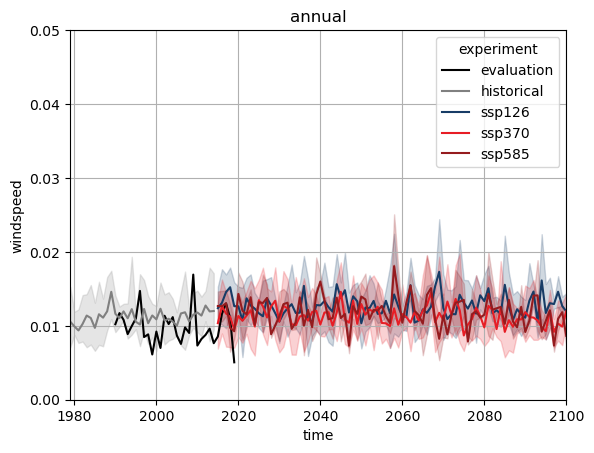

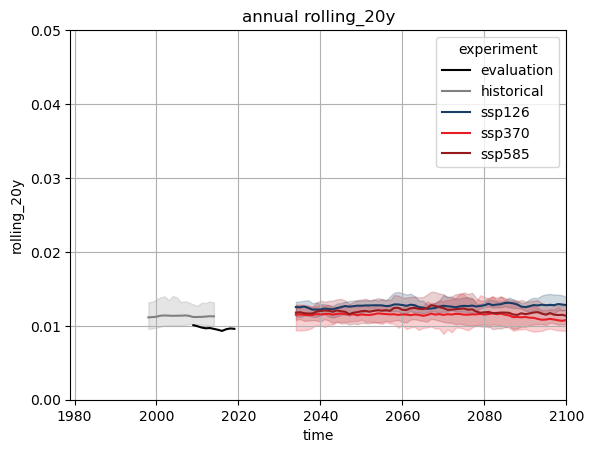

In [7]:
# for annual:
time_selection = "annual"
significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]=="annual") 
                         & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])

print(f"using {significance_list}")
run_list = ['evaluation_BARRA-R_r1i1p1f1'] + [experiment + run[10:]
                                              for experiment in ["historical", "ssp126", "ssp370", "ssp585"] 
                                              for run in significance_list]


# get the relevant runs and resample to annual
ds_ann = ds.sel(run = ds["run"].isin(run_list)).resample({"time":"YS"}).mean()

for window_size in [5,10,20]:
    ds_ann[f"rolling_{window_size}y"] = ds_ann[turbulence_index].rolling(time = window_size).mean()

df = ds_ann.to_dataframe().reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]

# plot it
plt.figure()
sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
plt.title( f"{time_selection}")
plt.ylim((0, 0.05))
plt.xlim((datetime.date(1979,1,1), datetime.date(2100,1,1)))
plt.grid()

for window_size in [20]: #[5,10,20]:
    plt.figure()
    sns.lineplot(df, x="time", y=f"rolling_{window_size}y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    plt.title( f"{time_selection} rolling_{window_size}y")
    plt.ylim((0, 0.05))
    plt.xlim((datetime.date(1979, 1, 1), datetime.date(2100, 1, 1)))
    plt.grid()

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']


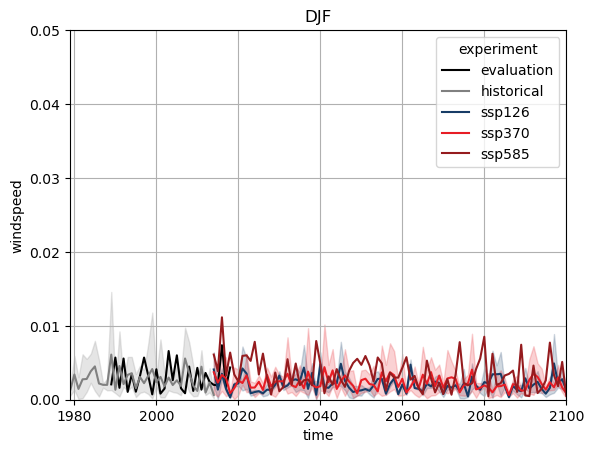

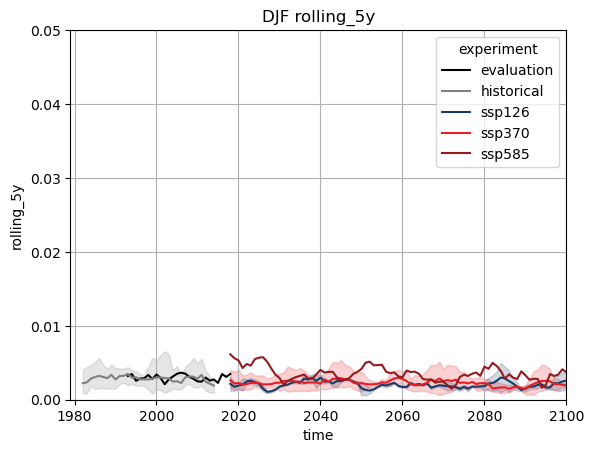

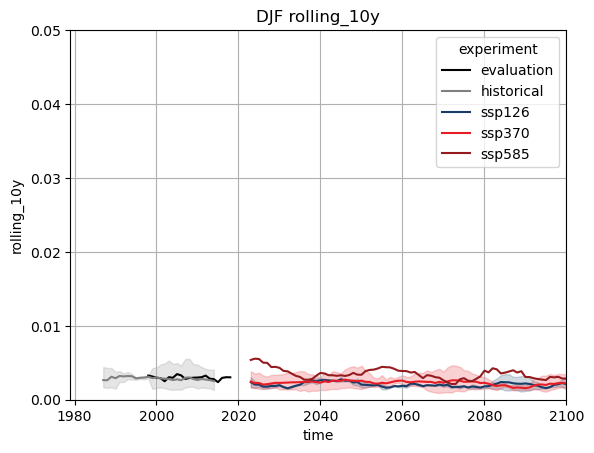

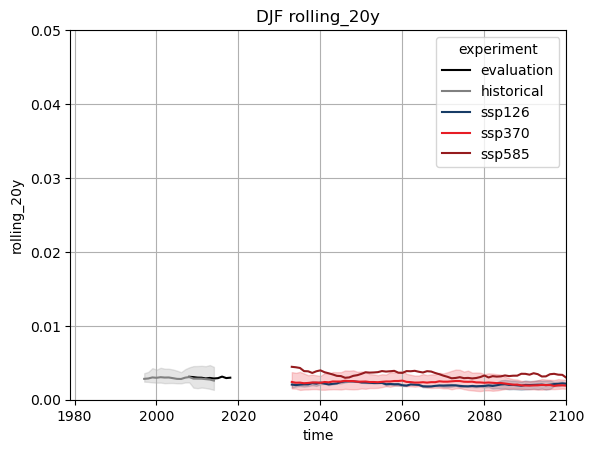

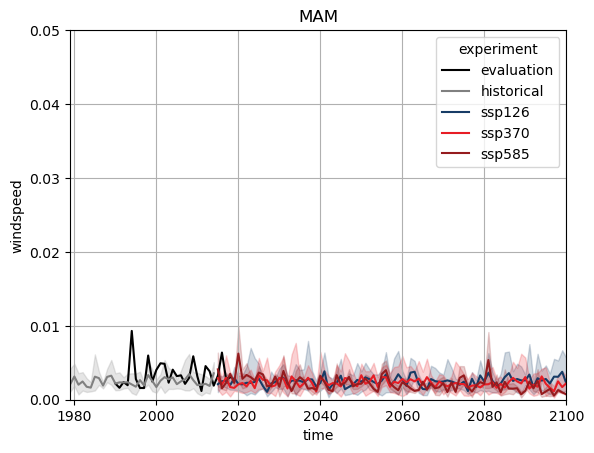

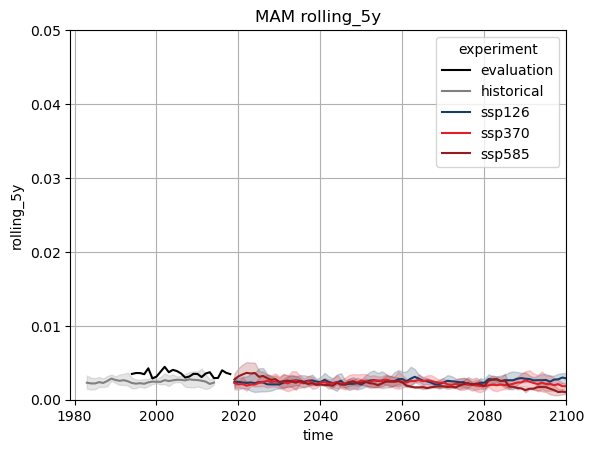

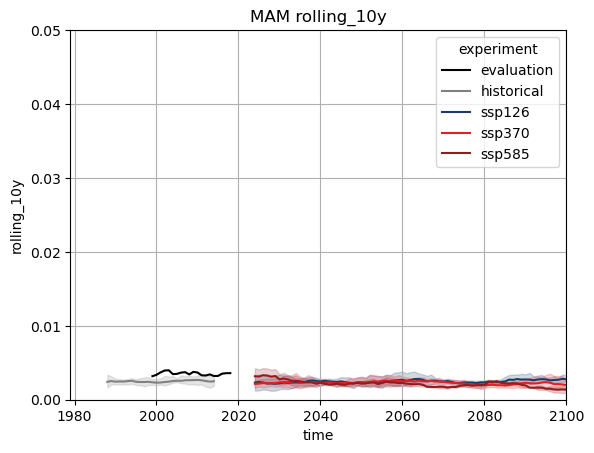

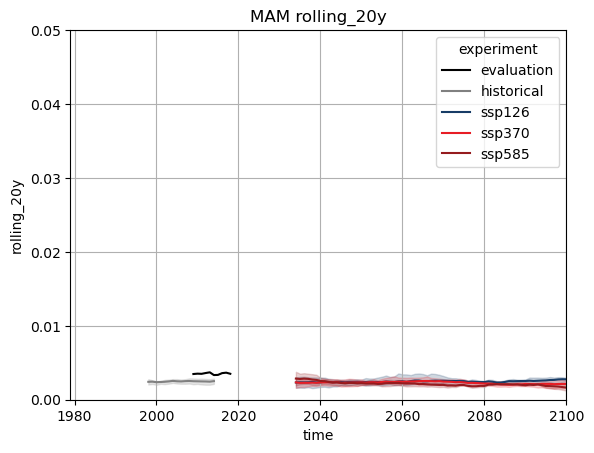

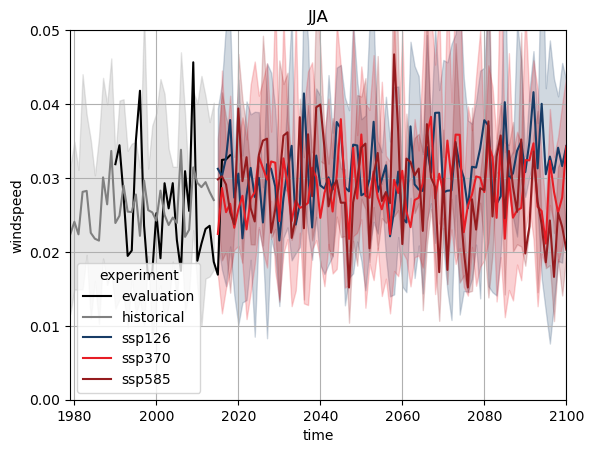

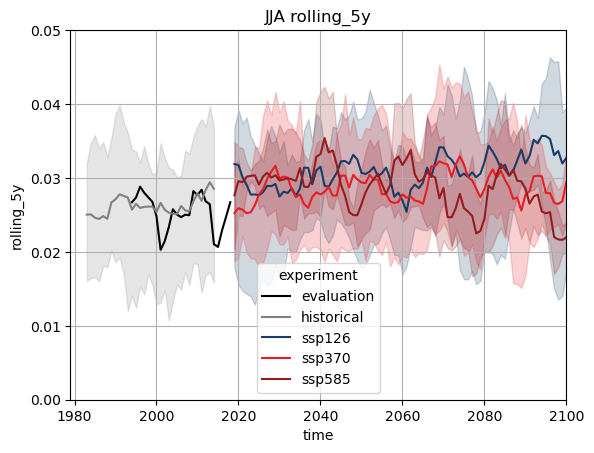

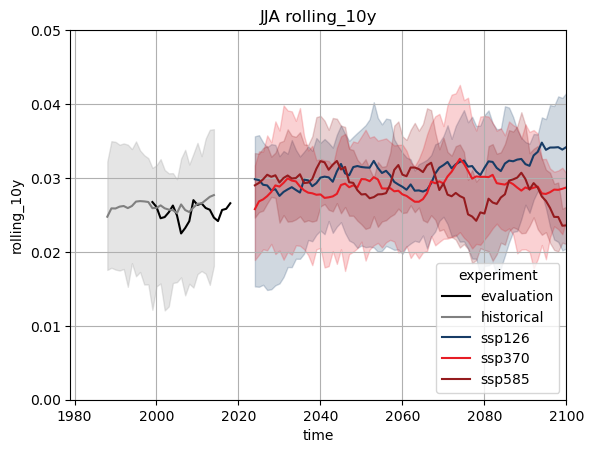

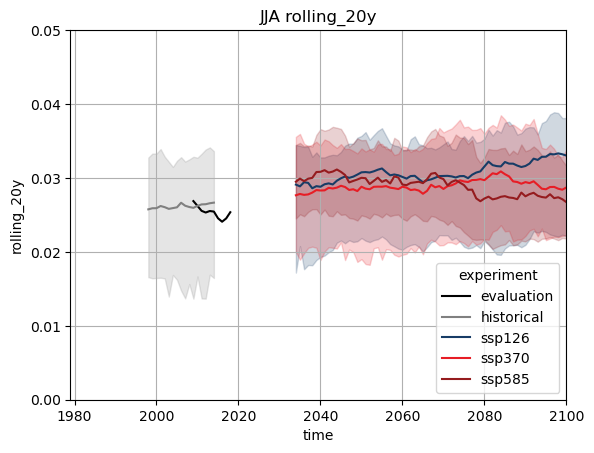

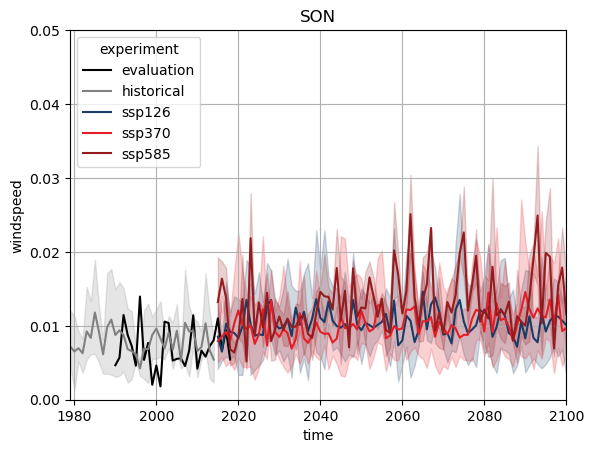

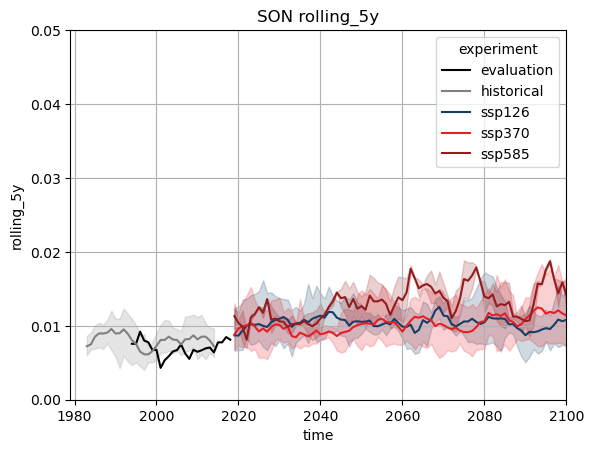

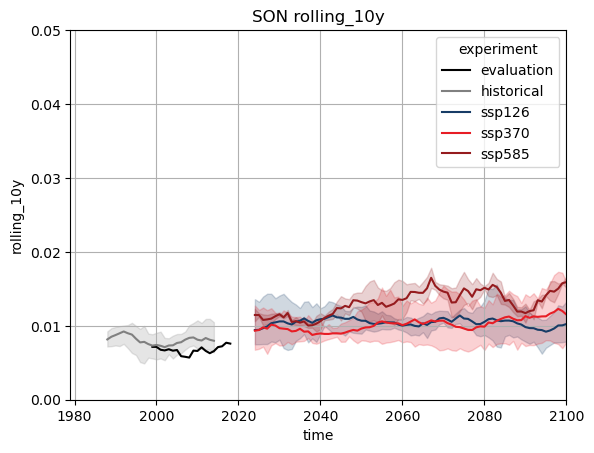

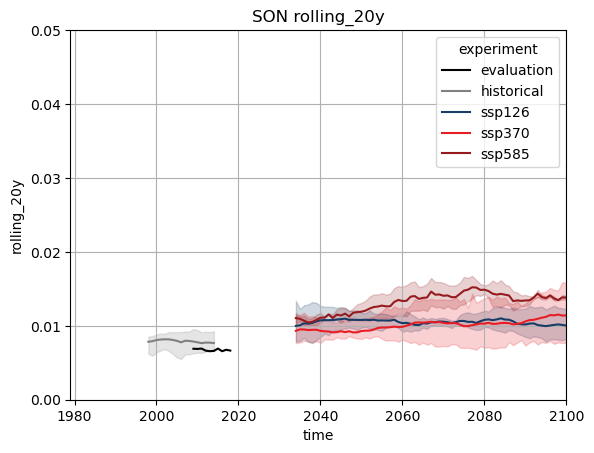

In [8]:
# for season:
for time_selection in ["DJF", "MAM", "JJA", "SON"]:
    significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]==time_selection) 
                             & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])
    
    print(f"using {significance_list}")
    run_list = ['evaluation_BARRA-R_r1i1p1f1'] + [experiment + run[10:]
                                                  for experiment in ["historical", "ssp126", "ssp370", "ssp585"] 
                                                  for run in significance_list]
    
    
    # get the relevant runs and resample to annual
    ds_ann = ds.sel({"time": (ds["time"].dt.season==time_selection), 
                     "run": ds["run"].isin(run_list)}).resample({"time":"QS-DEC"}).mean().resample({"time":"YS"}).mean()
    
    for window_size in [5,10,20]:
        ds_ann[f"rolling_{window_size}y"] = ds_ann[turbulence_index].rolling(time = window_size).mean()
    
    df = ds_ann.to_dataframe().reset_index()
    df["experiment"] = [x.split("_")[0] for x in df["run"]]
    
    # plot it
    plt.figure()
    sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    plt.title( f"{time_selection}")
    plt.ylim((0, 0.05))
    plt.xlim((datetime.date(1979,1,1), datetime.date(2100,1,1)))
    plt.grid()
    
    for window_size in [5,10,20]:
        plt.figure()
        sns.lineplot(df, x="time", y=f"rolling_{window_size}y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
        plt.title( f"{time_selection} rolling_{window_size}y")
        plt.ylim((0, 0.05))
        plt.xlim((datetime.date(1979, 1, 1), datetime.date(2100, 1, 1)))
        plt.grid()

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_MPI-ESM1-2-HR_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'histori

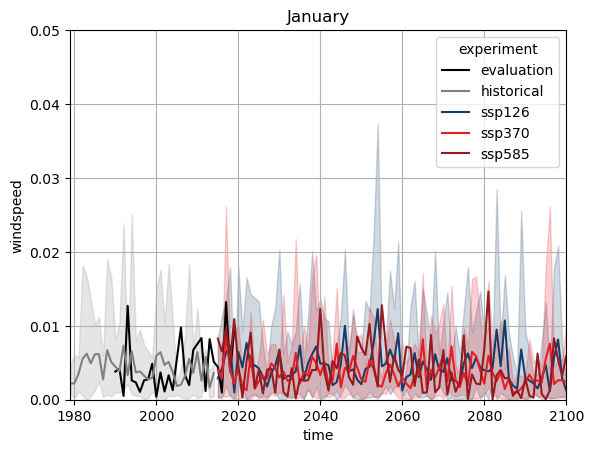

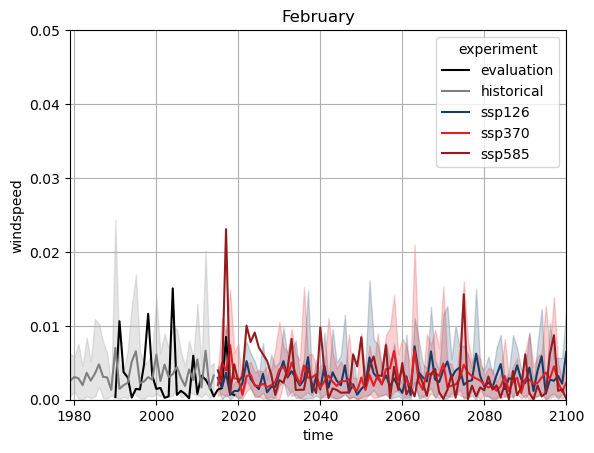

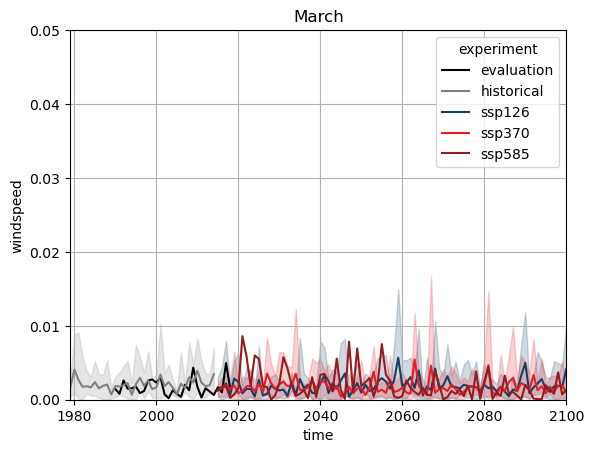

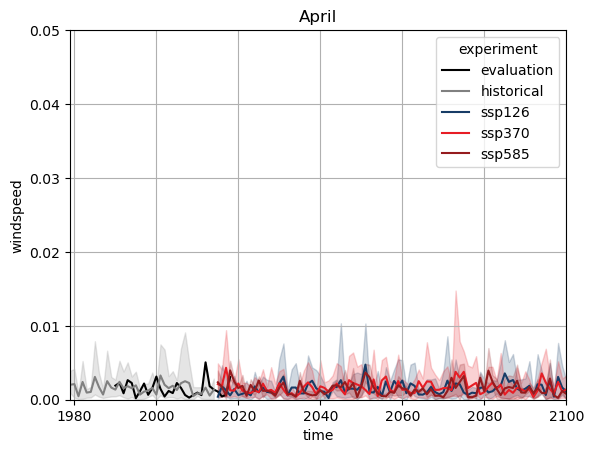

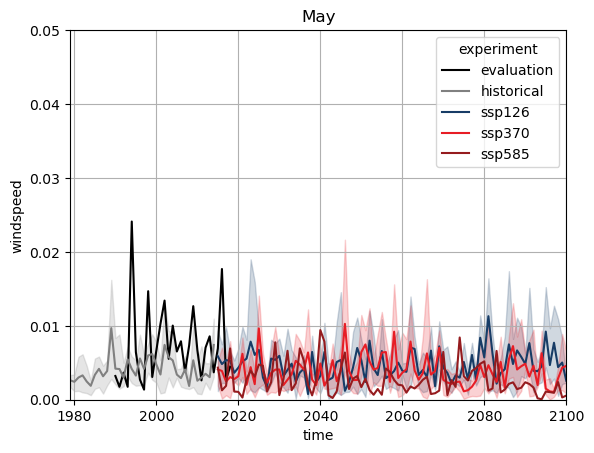

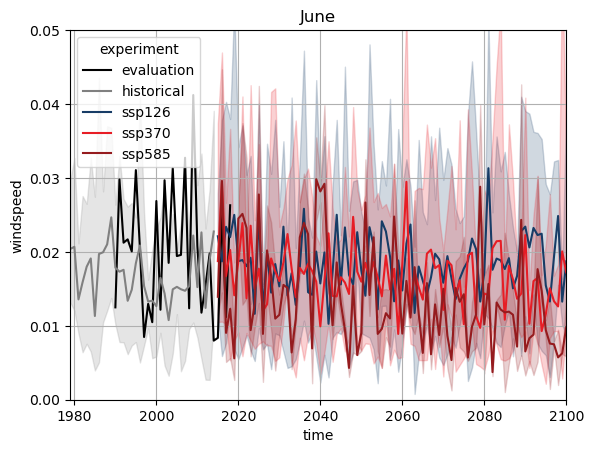

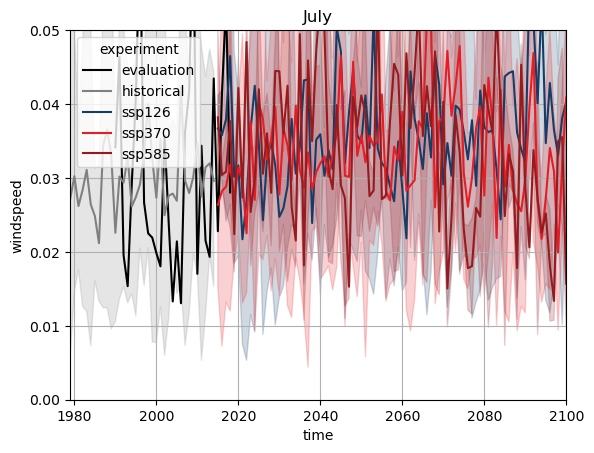

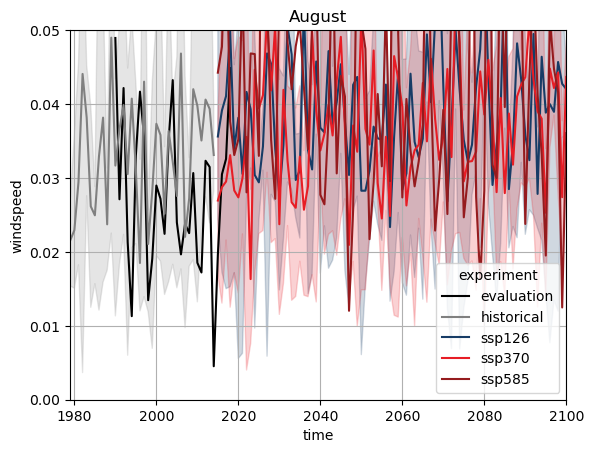

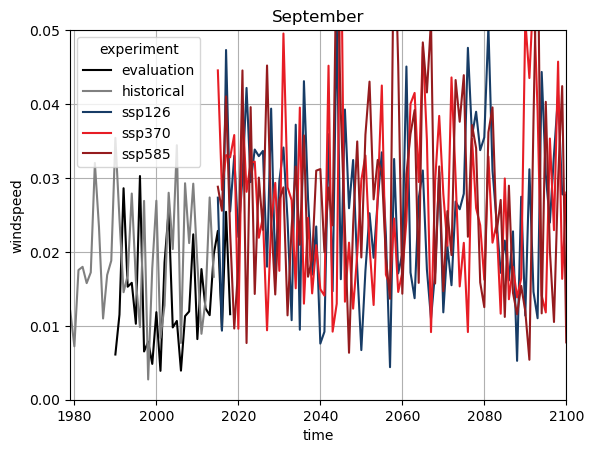

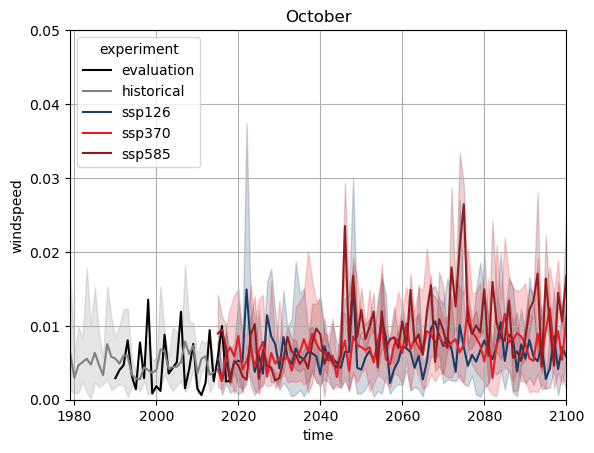

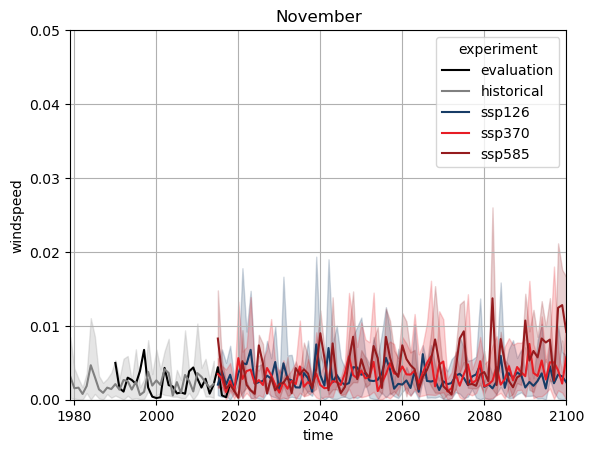

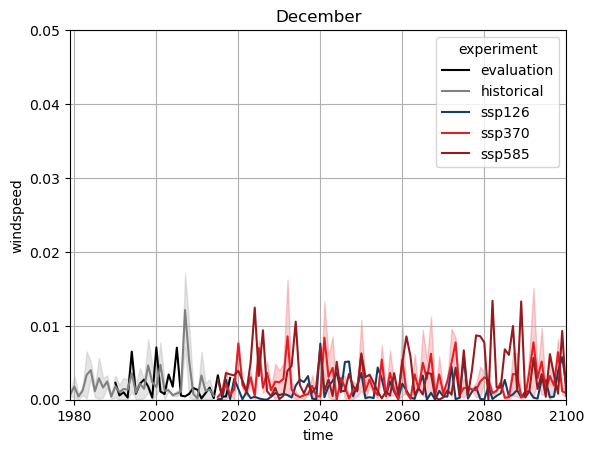

In [9]:
# for month:
for time_selection in np.arange(1,12+1):
    significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]==calendar.month_name[time_selection]) 
                             & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])
    
    print(f"using {significance_list}")
    run_list = ['evaluation_BARRA-R_r1i1p1f1'] + [experiment + run[10:]
                                                  for experiment in ["historical", "ssp126", "ssp370", "ssp585"] 
                                                  for run in significance_list]
    
    
    # get the relevant runs and resample to annual
    ds_ann = ds.sel({"time": (ds["time"].dt.month==time_selection), 
                     "run": ds["run"].isin(run_list)}).resample({"time":"YS"}).mean()
    
    for window_size in [5,10,20]:
        ds_ann[f"rolling_{window_size}y"] = ds_ann[turbulence_index].rolling(time = window_size).mean()
    
    df = ds_ann.to_dataframe().reset_index()
    df["experiment"] = [x.split("_")[0] for x in df["run"]]
    
    # plot it
    plt.figure()
    sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    plt.title( f"{calendar.month_name[time_selection]}")
    plt.ylim((0, 0.05))
    plt.xlim((datetime.date(1979,1,1), datetime.date(2100,1,1)))
    plt.grid()

    # for window_size in [5,10,20]:
    #     plt.figure()
    #     sns.lineplot(df, x="time", y=f"rolling_{window_size}y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    #     plt.title( f"{calendar.month_name[time_selection]} rolling_{window_size}y")
    #     plt.ylim((0, 0.05))
    #     plt.xlim((datetime.date(1979, 1, 1), datetime.date(2100, 1, 1)))
    #     plt.grid()

# maps

In [10]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)
baseline_time_slice = slice("1990", "2009")

turbulence_index = "windspeed"

In [11]:
evaluation = list_evaluation[1]
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" 
                        for run in [evaluation]],
                      concat_dim="run",
                      combine="nested",).sel({"lon":lon_slice, "time": baseline_time_slice})

ds=ds.load()

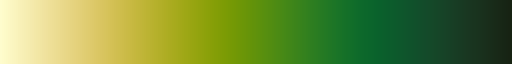

In [12]:
cmap_dict["ipcc_wind_seq"].set_under("white")
cmap_dict["ipcc_wind_seq"]

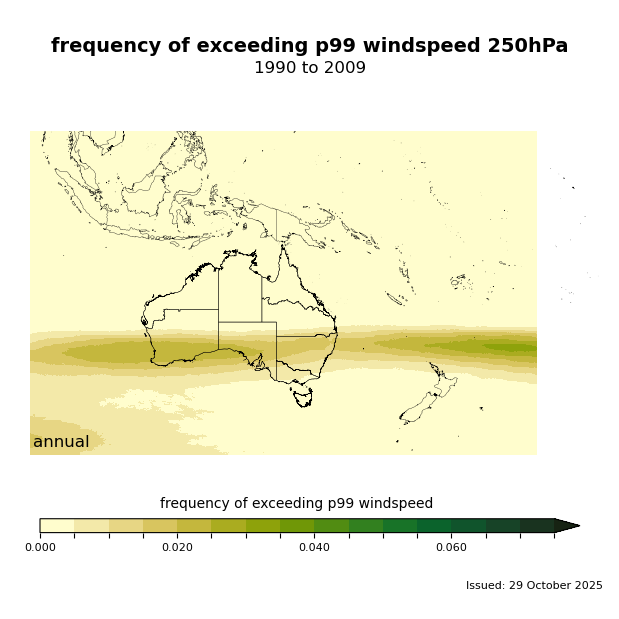

In [13]:
# annual
fig, axs = plot_acs_hazard_multi(nrows=1, 
                      ncols=1, 
                      ds_list=[ds.sel({"time":baseline_time_slice}).resample({"time":"YE"}).mean().mean(["time", "run"])[turbulence_index]],
                      mask_not_australia=False,
                      ticks=np.arange(0.00, 0.08, 0.005),
                      tick_interval=4,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(6, 6),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      date_range="1990 to 2009",
                      subplot_titles="annual",
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


    


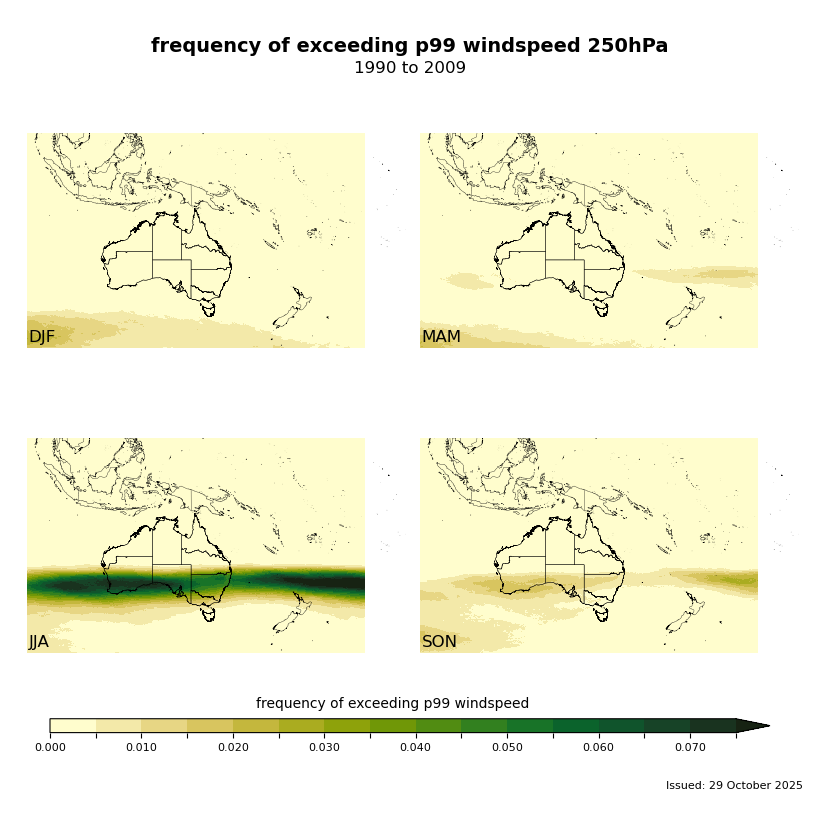

In [14]:
# seasons
ds_seas = ds.resample({"time":"QS-DEC"}).mean()
season_list = ["DJF", "MAM", "JJA", "SON"]

fig, axs = plot_acs_hazard_multi(nrows=2, 
                      ncols=2, 
                      ds_list=[ds_seas.sel({"time": ds_seas.time.dt.season == time_selection})\
                               .resample({"time":"YE"}).mean()\
                               .sel({"time":baseline_time_slice})\
                               .mean(["time", "run"])[turbulence_index]\
                               for time_selection in season_list],
                      mask_not_australia=False,
                      ticks=np.arange(0.0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(8, 8),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      date_range="1990 to 2009",
                      subplot_titles=season_list,
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


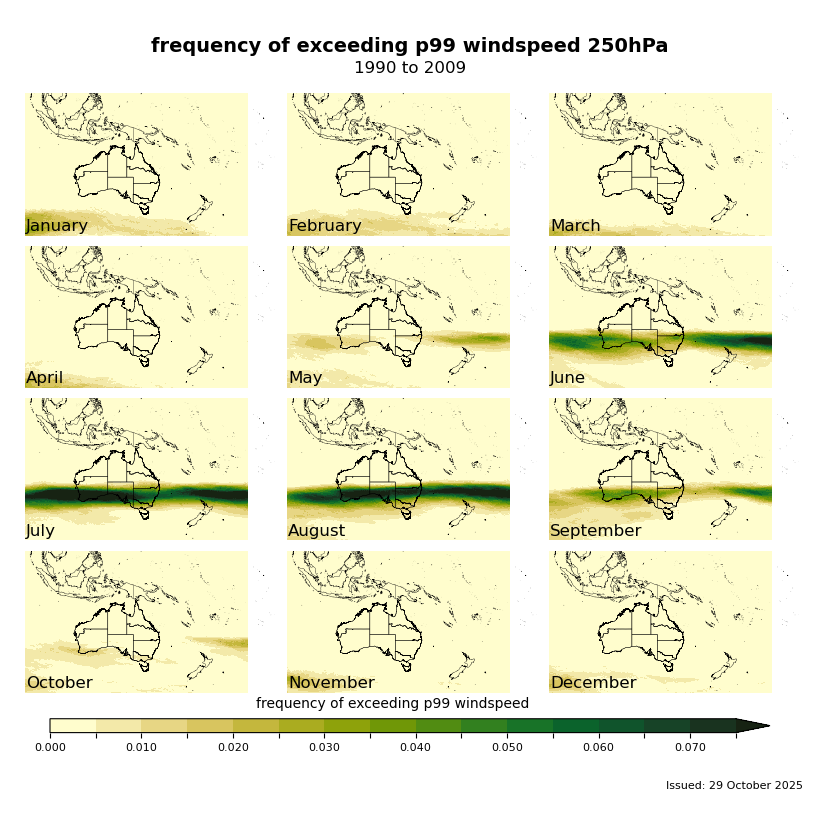

In [15]:
# months
fig, axs = plot_acs_hazard_multi(nrows=4, 
                      ncols=3, 
                      ds_list=[ds.sel({"time": ds.time.dt.month == time_selection})\
                               .resample({"time":"YE"}).mean()\
                               .sel({"time":baseline_time_slice})\
                               .mean(["time", "run"])[turbulence_index]\
                               for time_selection in np.arange(1,12+1)],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(8, 8),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      date_range="1990 to 2009",
                      subplot_titles=[calendar.month_name[time_selection] for time_selection in np.arange(1,12+1)],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );

# time evolution of mapped indices


In [ ]:
# need to fix missing files
# need to combine

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']


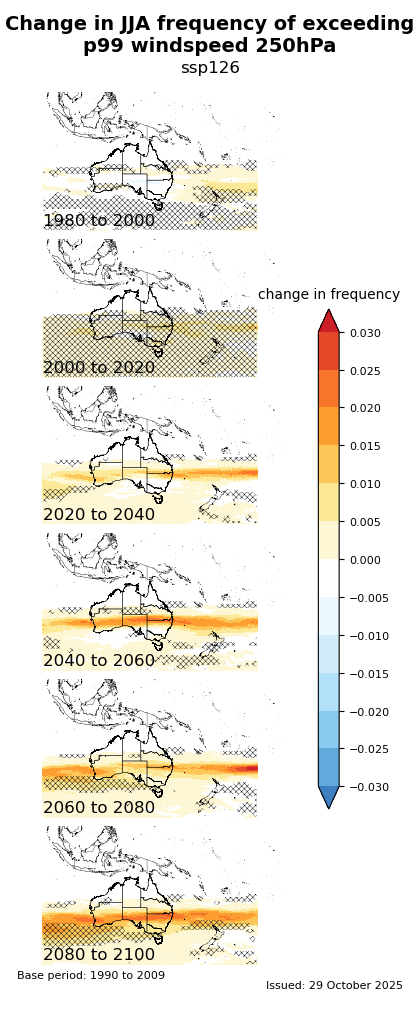

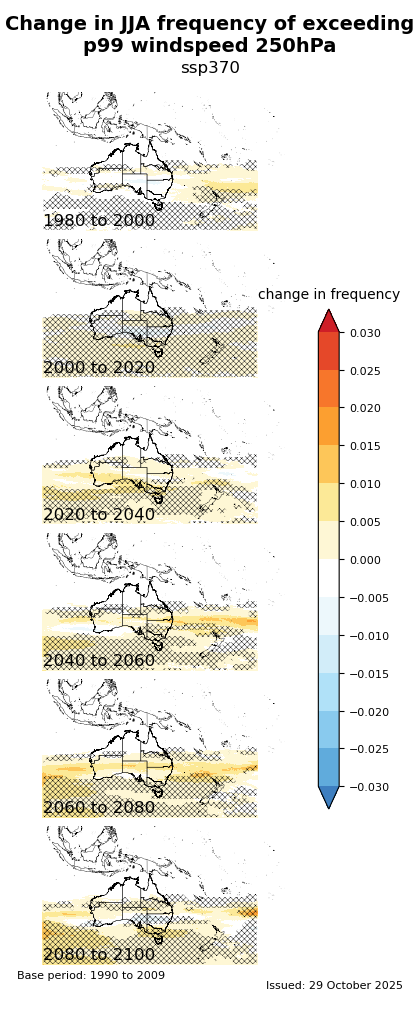

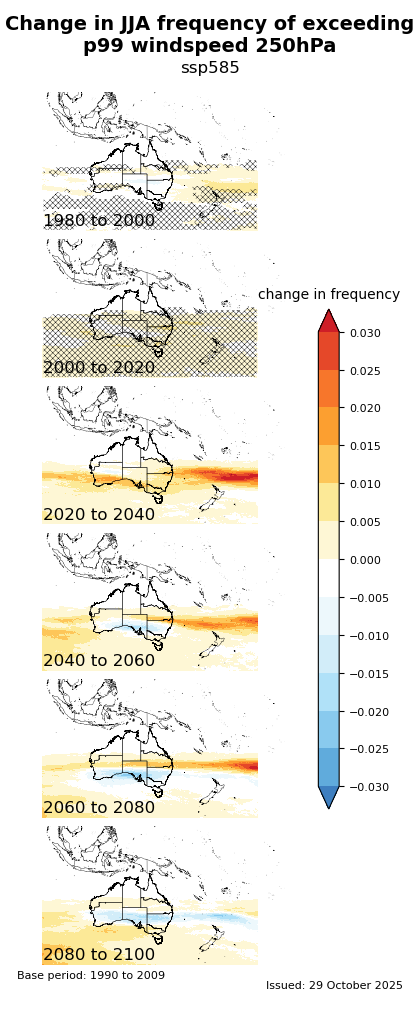

In [19]:
# for JJA
time_selection = "JJA"

time_slices = [("1980", "2000"), 
              ("2000", "2020"), 
              ("2020", "2040"),
              ("2040", "2060"),
              ("2060", "2080"),
              ("2080", "2100"),]

significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]==time_selection) 
                             & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])

#set how many models need to agree for the maps to be stippled
agreement_threshold = 4

print(f"using {significance_list}")

for experiment in ["ssp126", "ssp370", "ssp585"]:
    run_list = [experiment + run[10:]
                  for experiment in ["historical", experiment,] 
                  for run in significance_list]
    # get the list of files we need but check they exist!
    glob_list = glob.glob("/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_*.nc")
    desired_list = [f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" 
                                for run in run_list]
    filelist = list(set(desired_list)&set(glob_list))
    
    ds = xr.open_mfdataset(filelist,
                          concat_dim="run",
                          combine="nested",
                          preprocess= lambda ds: ds.sel({"lon":lon_slice, 
                                                         "time": ds.time.dt.season == time_selection,
                                                        }),
                          # errors="ignore",
                          )
    # get the relevant runs and resample to annual
    ds_ann = ds.resample({"time":"QS-DEC"}).mean()\
                .resample({"time":"YS"}).mean()
    ds_ann.load()
    
    baseline = ds_ann[turbulence_index].sel({"time":baseline_time_slice}).mean(["time", "run"])
    
    #stippling for agreement
    agreement_list = [(((((((ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time"])- baseline)>0).sum(["run"]) >= agreement_threshold)) +
                         (((ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time"])- baseline)<0).sum(["run"]) >= agreement_threshold))\
                        .coarsen({"lat":10, "lon":10}, boundary="pad").mean()) >0.2)
                                          for start_year, end_year in time_slices]
    
    fig, axs = plot_acs_hazard_multi(nrows=6, 
                          ncols=1, 
                          ds_list=[ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time", "run"]) - baseline
                                   for start_year, end_year in time_slices],
                          stippling_list= agreement_list,
                          mask_not_australia=False,
                          ticks=np.arange(-0.03, 0.0301, 0.005),
                          vcentre=0,
                          tick_interval=1,
                          cbar_extend="both",
                          cbar_label=f"change in frequency",
                          cbar_location="right",
                          figsize=(4, 10),
                          title=f"Change in {time_selection} frequency of exceeding p99 {turbulence_index} 250hPa",
                          date_range=f"{experiment}",
                          subplot_titles=[f"{start_year} to {end_year}" for start_year, end_year in time_slices],
                          xlim=(88.04 , 207.9),
                          ylim=(-53.58 , 13.63),
                          coastlines=True,
                          projection=ccrs.PlateCarree(130),
                          cmap=cmap_dict["anom"],
                          watermark="",
                          show_copyright=False,
                          baseline= "1990 to 2009",
                         );

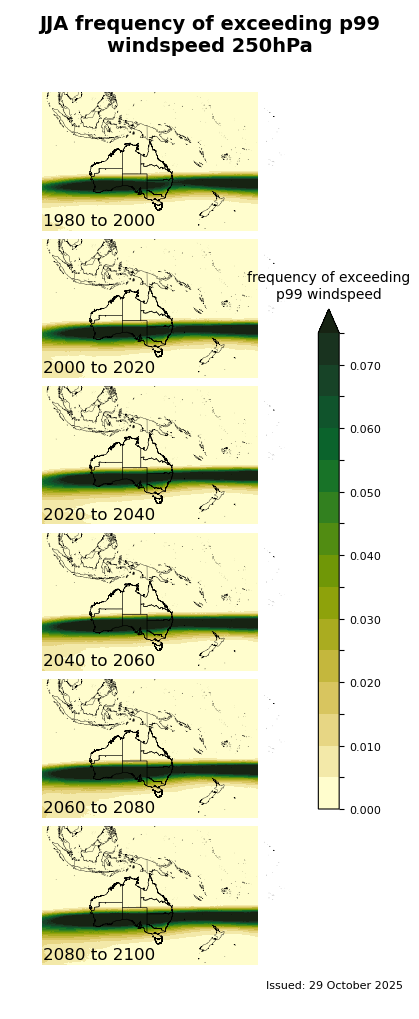

In [20]:
fig, axs = plot_acs_hazard_multi(nrows=6, 
                      ncols=1, 
                      ds_list=[ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time", "run"])
                               for start_year, end_year in time_slices],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      cbar_location="right",
                      figsize=(4, 10),
                      title=f"{time_selection} frequency of exceeding p99 {turbulence_index} 250hPa",

                      subplot_titles=[f"{start_year} to {end_year}" for start_year, end_year in time_slices],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );

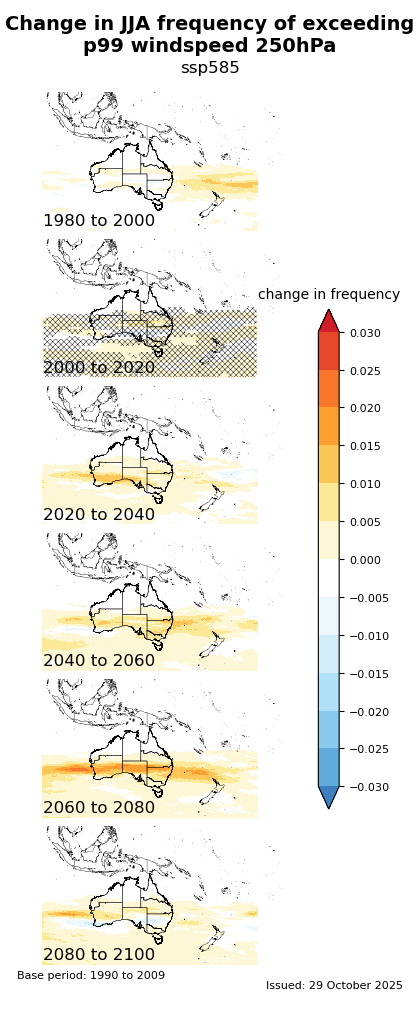

In [147]:
#stippling for agreement
agreement_list = [(((((((ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time"])- baseline)>0).sum(["run"]) >= agreement_threshold)) +
                     (((ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time"])- baseline)<0).sum(["run"]) >= agreement_threshold))\
                    .coarsen({"lat":10, "lon":10}, boundary="pad").mean()) >0.2)
                                      for start_year, end_year in time_slices]

fig, axs = plot_acs_hazard_multi(nrows=6, 
                      ncols=1, 
                      ds_list=[ds_ann[turbulence_index].sel({"time":slice(start_year, end_year)}).mean(["time", "run"]) - baseline
                               for start_year, end_year in time_slices],
                      stippling_list= agreement_list,
                      mask_not_australia=False,
                      ticks=np.arange(-0.03, 0.0301, 0.005),
                      vcentre=0,
                      tick_interval=1,
                      cbar_extend="both",
                      cbar_label=f"change in frequency",
                      cbar_location="right",
                      figsize=(4, 10),
                      title=f"Change in {time_selection} frequency of exceeding p99 {turbulence_index} 250hPa",
                      date_range=f"{experiment}",
                      subplot_titles=[f"{start_year} to {end_year}" for start_year, end_year in time_slices],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["anom"],
                      watermark="",
                      show_copyright=False,
                      baseline= "1990 to 2009",
                     );